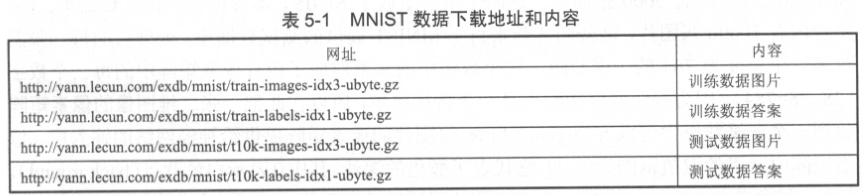

In [2]:
import tensorflow as tf

# MNIST数据处理

In [5]:
# 自动下载并转化MNIST数据的格式
from tensorflow.examples.tutorials.mnist import input_data

# 载入MNIST数据集，如果指定位置无数据
# 那么Tensorflow会自动从表5-1给出的网址下载数据
# 对于出现问题URLError: <urlopen error [Errno 104] Connection reset by peer>，参考https://www.freesion.com/article/7212130867/
mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST/', False, one_hot=True)

# 打印训练集大小：55000
print('Training data size: ', mnist.train.num_examples)

# 打印验证集大小：5000
print('Validating data size: ', mnist.validation.num_examples)

# 打印测试集大小：10000
print('Testing data size: ', mnist.test.num_examples)

# 打印训练集部分数据
print('Example training data: ', mnist.train.images[0])

# 打印对应训练集标签
print('Example training data label: ', mnist.train.labels[0])

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz
Training data size:  55000
Validating data size:  5000
Testing data size:  10000
Example training data:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        

In [6]:
batch_size = 100
xs, ys = mnist.train.next_batch(batch_size)

print('X shape: ', xs.shape)
print('Y shape: ', ys.shape)

X shape:  (100, 784)
Y shape:  (100, 10)


# 训练神经网络

In [6]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# MNIST数据集相关的常数
INPUT_NODE = 784  # 输入层节点数，等于图片像素
OUTPUT_NODE = 10  # 输出层节点数，10个数字的向量

# 配置神经网络参数
LAYER1_NODE = 500  # 隐藏层节点数，这里使用只有一个隐藏层且为500个节点的网络结构
BATCH_SIZE = 100  # 一个训练batch的训练数据个数。数字越小越接近随机梯度下降
LEARNING_RATE_BASE = 0.8  # 基础学习率
LEARNING_RATE_DECAY = 0.99  # 学习率的衰减率
REGULARIZATION_RATE = 0.0001  # 描述模型复杂度的正则化项在损失函数中的系数
TRAINING_STEPS = 20000  # 训练轮数
MOVING_AVERAGE_DECAY = 0.99  # 滑动平均衰减率

# 辅助函数：给定神经网络的输入和所有参数，计算神经网络的前向传播结果
# 该函数使用ReLU激活函数的三层全连接神经网络
# 通过加入隐藏层实现多层网络结构，通过激活函数实现去线性化
# 也支持传入用于计算参数平均值的类，方便在测试时使用滑动平均模型
def inference(input_tensor, avg_class, weights1, biases1, weights2, biases2):
    # 当没有提供滑动平均类时，直接使用参数当前的取值
    if avg_class == None:
        # 计算隐藏层的前向传播结果，这里使用了ReLU激活函数
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights1) + biases1)
        
        # 计算输出层的前向传播结果
        # 因为在计算损失函数时会一并计算softmax函数，所以这里不需要加入激活函数
        # 而且不加入softmax不会影响预测结果，因为预测时使用的是不同类别对应节点
        # 输出值的相对大小，有没有softmax层对最后分类结果的计算没有影响
        # 于是在计算整个神经网络的前向传播时可以不加入最后的softmax层
        return tf.matmul(layer1, weights2) + biases2
    else:
        # 首先使用avg_class.average函数来计算得出变量的滑动平均值
        # 然后再计算相应的神经网络前向传播结果
        layer1 = tf.nn.relu(tf.matmul(input_tensor, avg_class.average(weights1))
                           + avg_class.average(biases1))
        return tf.matmul(layer1, avg_class.average(weights2)) + avg_class.average(biases2)

# 训练模型的过程
def train(mnist):
    x = tf.placeholder(tf.float32, [None, INPUT_NODE], name='x-input')
    y_ = tf.placeholder(tf.float32, [None, OUTPUT_NODE], name='y-input')
    
    # 生成隐藏层的参数
    weights1 = tf.Variable(tf.truncated_normal([INPUT_NODE, LAYER1_NODE], stddev=0.1))
    biases1 = tf.Variable(tf.constant(0.1, shape=[LAYER1_NODE]))
    
    # 生成输出层的参数
    weights2 = tf.Variable(tf.truncated_normal([LAYER1_NODE, OUTPUT_NODE], stddev=0.1))
    biases2 = tf.Variable(tf.constant(0.1, shape=[OUTPUT_NODE]))
    
    # 计算在当前参数下神经网络前向传播的结果
    # 这里给出的用于计算滑动平均的类为None，所有不会使用参数的滑动平均值
    y = inference(x, None, weights1, biases1, weights2, biases2)
    
    # 定义存储训练轮数的变量
    # 该变量不需要计算滑动平均值，所以指定该变量为不可训练变量
    # 在训练神经网络时，一般会将代表训练轮数的变量指定为不可训练的参数
    global_step = tf.Variable(0, trainable=False)
    
    # 给定滑动平均衰减率和训练轮数的变量，初始化滑动平均类
    # 给定训练轮数的变量可以加快训练早期变量的更新速度
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, 
                                                          global_step)
    # 在所有代表神经网络参数的变量上使用滑动平均，其他辅助变量(如global_step)就不需要了
    # tf.trainable_variables返回的就是图上集合GraphKeys.TRAINABLE_VARIABLES中的元素
    # 这个集合的元素就是所有没有指定trainable=False的参数
    variables_averages_op = variable_averages.apply(tf.trainable_variables())
    
    # 计算使用了滑动平均之后的前向传播结果
    # 滑动平均不会改变变量本身的取值，而是会维护一个影子变量来记录其滑动平均值
    # 所以当需要这个滑动平均值时，需要明确调用average函数
    average_y = inference(x, variable_averages, weights1, biases1, weights2, biases2)
    
    # 计算交叉熵作为刻画预测值和真实值之间差距的损失函数
    # 当分类问题只有一个正确答案时
    # 可用sparse_softmax_cross_entropy_with_logits函数来加速交叉熵的计算
    # MNIST问题中的图片只包含0~9中的一个数字，所以可以使用这个函数计算交叉熵损失
    # 这个函数的第一个参数是神经网络不包括softmax层的前向传播结果
    # 第二个参数是训练数据的正确答案
    # 因为标准答案是一个长度为10的一维数组，而该函数需要提供一个数字
    # 所以需要使用tf.argmax函数来得到正确答案对应的类别编号
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y,
                                                                   labels=tf.argmax(y_, 1))
    # 计算在当前batch中所有样例的交叉熵平均值
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    
    # 计算L2正则化损失函数
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    # 计算模型的正则化损失，一般只计算神经网络边上权重的正则化损失，而不使用偏置项
    regularization = regularizer(weights1) + regularizer(weights2)
    # 总损失等于交叉熵损失和正则化损失的和
    loss = cross_entropy_mean + regularization
    # 设置指数衰减的学习率,参数分别是
    # 基础学习率，当前迭代的轮数，过完所有的训练数据需要迭代的次数，学习率的衰减速度
    learning_rate = tf.train.exponential_decay(LEARNING_RATE_BASE,
                                              global_step,
                                              mnist.train.num_examples / BATCH_SIZE,
                                              LEARNING_RATE_DECAY)
    
    # 使用梯度下降优化算法来优化损失函数
    # 注意这里损失函数包含交叉熵损失和L2正则化损失
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,
                                                                          global_step)
    
    # 每过一遍数据需要通过反向传播来更新神经网络中的参数和参数的滑动平均值
    # 为了一次完成多个操作，Tensorflow提供两种方式，下述注释方法和非注释方法等价
    # train_op = tf.group(train_step, variables_averages_op)
    with tf.control_dependencies([train_step, variables_averages_op]):
        train_op = tf.no_op(name='train')
        
        
    # 检验使用了滑动平均模型的神经网络前向传播结果是否正确
    # tf.argmax(average_y, 1)计算每一个样例的预测答案
    # 其中average_y是一个batch_size * 10的二维数组，每一行代表一个样例的前向传播结果
    # tf.argmax的第二个参数"1"表示选取的最大值的操作仅在第一个维度中进行
    # 也就是说，只在每一行选取最大值对应的下标，于是得到一个长度为batch的一维数组
    # 这个一维数组中的值就表示了每一个样例对应的数字识别结果
    # tf.equal判断两个张量的每一维是否相等，如果相等返回True，否则是False
    correct_prediction = tf.equal(tf.argmax(average_y, 1), tf.argmax(y_, 1))
    # 这个运算首先将一个布尔型的数值转换为实数型，然后计算平均值
    # 这个平均值就是这组数据上的正确率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # 初始化会话并开始训练过程
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        # 准备验证数据
        # 一般在神经网络的训练过程中会通过验证数据来大致判断停止的条件和评判训练的结果
        validate_feed = {x: mnist.validation.images,
                        y_: mnist.validation.labels}
        
        # 准备测试数据
        test_feed = {x: mnist.test.images, y_: mnist.test.labels}
        
        # 迭代训练神经网络
        for i in range(TRAINING_STEPS):
            # 每1000轮输出一次在验证数据集上的测试结果
            if i % 1000 == 0:
                # 计算滑动平均模型在验证数据上的结果
                # 因为MNIST数据集比较小，所有一次可以处理所有的验证数据
                # 为了计算方便，没有将验证数据划分为更小的batch
                # 当神经网络模型比较复杂或验证数据比较大时，太大的batch
                # 会导致计算时间过长甚至发生内存溢出的错误
                validate_acc = sess.run(accuracy, feed_dict=validate_feed)
                print('After %d training step(s), validation accuracy \
                    using average model is %g ' % (i, validate_acc))
                
            # 产生这轮使用的一个batch的训练数据，并运行训练过程
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            sess.run(train_op, feed_dict={x: xs, y_: ys})
        
        # 训练结束之后，在测试数据上检测神经网络模型的最终正确率
        test_acc = sess.run(accuracy, feed_dict=test_feed)
        print('After %d training step(s), test accuracy using average \
            model is %g' % (TRAINING_STEPS, test_acc))
        
# 主程序入口
def main(argv=None):
    mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST/', False, one_hot=True)
    train(mnist)

# Tensorflow提供的一个主程序入口，下面的函数会调用定义的main函数
if __name__ == '__main__':
    tf.app.run()

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz
After 0 training step(s), validation accuracy                     using average model is 0.115 
After 1000 training step(s), validation accuracy                     using average model is 0.9774 
After 2000 training step(s), validation accuracy                     using average model is 0.983 
After 3000 training step(s), validation accuracy                     using average model is 0.9842 
After 4000 training step(s), validation accuracy                     using average model is 0.985 
After 5000 training step(s), validation accuracy                     using average model is 0.9854 
After 6000 training step(s), validation accuracy                     using average model is 0.984 
After 7000 training step(s), validation accuracy         

SystemExit: 

/opt/Anaconda/envs/tensorflow1.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


由上可以从第4000轮开始，模型在验证集上的表现开始波动，这说明模型已经接近极小值了，所以迭代也就可以结束了

# 变量管理

In [9]:
# 下面这两个定义是等价的，由于不能同名，这里分别使用v1,v2表示名字
v = tf.get_variable('v1', shape=[1], initializer=tf.constant_initializer(1.0))
v = tf.Variable(tf.constant(1.0, shape=[1]), name='v2')

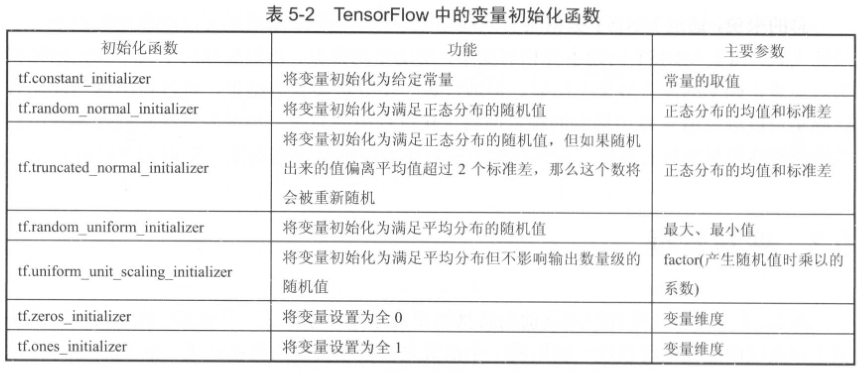

In [10]:
# 在名字为foo的命名空间内创建名字为v的变量
with tf.variable_scope('foo'):
    v = tf.get_variable('v', [1], initializer=tf.constant_initializer(1.0))
    
# 在生成上下文管理器时，将参数reuse设置为True
# 这样tf.get_variable函数将直接获取已经声明的变量（不能获取没有创建的变量）
with tf.variable_scope('foo', reuse=True):
    v1 = tf.get_variable('v', [1])
    print(v == v1)

True


In [12]:
with tf.variable_scope('root'):
    # 可以通过下述函数来获取当前上下文管理器中reuse参数的取值
    print(tf.get_variable_scope().reuse)
    
    with tf.variable_scope('foo', reuse=True):
        print(tf.get_variable_scope().reuse)
        
        with tf.variable_scope('bar'):
            # 新建一个嵌套的上下文管理器但不指定reuse
            # 这时reuse的取值会和外面一层保持一致
            print(tf.get_variable_scope().reuse)
    
    print(tf.get_variable_scope().reuse)

False
True
True
False


In [3]:
v1 = tf.get_variable('v', [1])
# 输出v:0，'v'表示变量的名称，':0'表示这个变量是生成变量这个运算的第一个结果
print(v1.name)

with tf.variable_scope('foo'):
    v2 = tf.get_variable('v', [1])
    print(v2.name)
    
with tf.variable_scope('foo'):
    with tf.variable_scope('bar'):
        v3 = tf.get_variable('v', [1])
        print(v3.name)
        
    v4 = tf.get_variable('v1', [1])
    print(v4.name)
    
# 创建一个名称为空的命名空间，并设置reuse=True
with tf.variable_scope('', reuse=True):
    v5 = tf.get_variable('foo/bar/v', [1])
    print(v5 == v3)
    
    v6 = tf.get_variable('foo/v1', [1])
    print(v6 == v4)

v:0
foo/v:0
foo/bar/v:0
foo/v1:0
True
True


通过该变量管理方法，可以对计算前向传播结果的函数做一些改进：
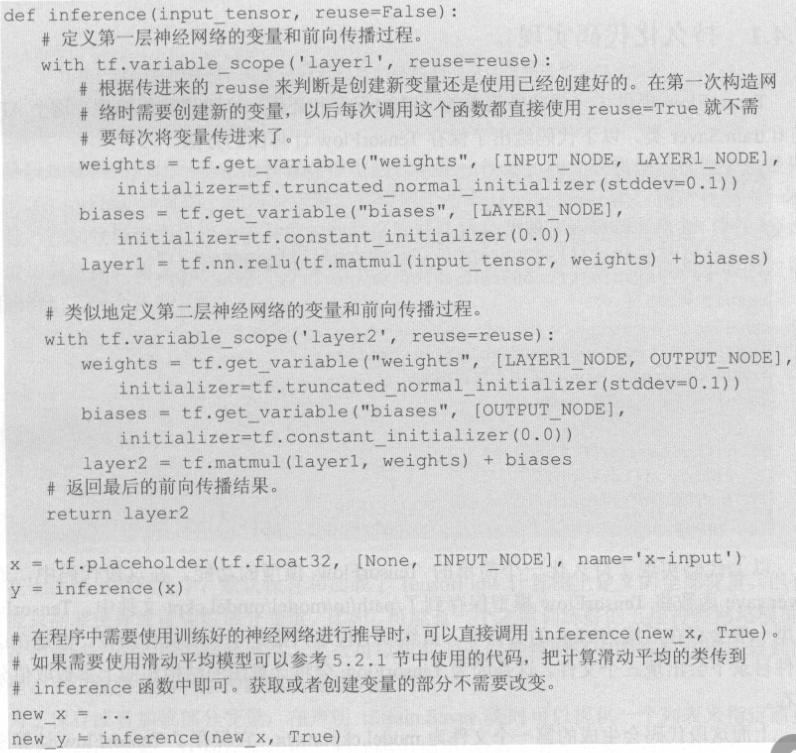

# 模型持久化

In [20]:
import tensorflow as tf

# 清除默认图的堆栈，并设置全局图为默认图 
tf.reset_default_graph()

# 声明两个变量并计算它们的和
v1 = tf.Variable(tf.constant(1.0, shape=[1]), name='v1')
v2 = tf.Variable(tf.constant(2.0, shape=[1]), name='v2')
result = v1 + v2

init_op = tf.global_variables_initializer()

# 声明tf.train.Saver类用于保存模型
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init_op)
    # 将模型保存到v1_and_v2.ckpt文件
    # tensorflow模型一般都存在后缀为.ckpt文件中
    saver.save(sess, '/opt/jupyter_files/model-saves/v1_and_v2/v1_and_v2.ckpt')

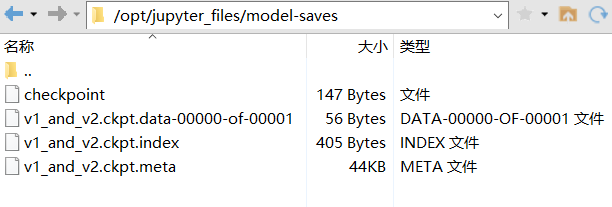
**checkpoint** 文件保存了一个目录下所有的模型文件列表

**.ckpt.meta** 文件保存了Tensorflow计算图的结构

**.ckpt.data-00000-of-00001** 文件保存了Tensorflow当前参数值

**.ckpt.index** 文件保存了Tensorflow当前参数名

In [8]:
import tensorflow as tf

# 清除默认图的堆栈，并设置全局图为默认图 
tf.reset_default_graph()

# 使用和保存模型代码中一样的方式来声明变量
v1 = tf.Variable(tf.constant(1.0, shape=[1]), name='v1')
v2 = tf.Variable(tf.constant(2.0, shape=[1]), name='v2')
result = v1 + v2

saver = tf.train.Saver()

with tf.Session() as sess:
    # 加载已经保存的模型，并通过已经保存的模型中变量的值来计算加法
    saver.restore(sess, '/opt/jupyter_files/model-saves/v1_and_v2/v1_and_v2.ckpt')
    print(sess.run(result))

INFO:tensorflow:Restoring parameters from /opt/jupyter_files/model-saves/v1_and_v2/v1_and_v2.ckpt
[3.]


In [9]:
# 查看指定保存模型的变量列表
from tensorflow.contrib.framework.python.framework import checkpoint_utils

var_list = checkpoint_utils.list_variables("/opt/jupyter_files/model-saves/v1_and_v2/v1_and_v2.ckpt")
for v in var_list:
    print(v)

('v1', [1])
('v2', [1])


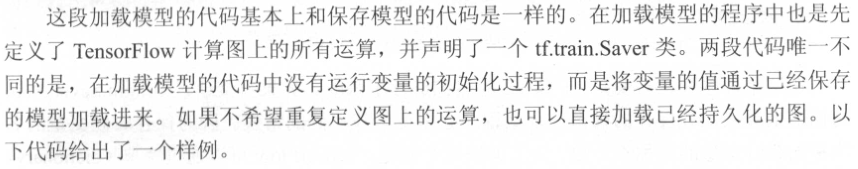

In [10]:
import tensorflow as tf

# 清除默认图的堆栈，并设置全局图为默认图 
tf.reset_default_graph()

# 直接加载持久化的图
saver = tf.train.import_meta_graph('/opt/jupyter_files/model-saves/v1_and_v2/v1_and_v2.ckpt.meta')

with tf.Session() as sess:
    saver.restore(sess, '/opt/jupyter_files/model-saves/v1_and_v2/v1_and_v2.ckpt')
    # 通过张量的名称来获取变量
    print(sess.run(tf.get_default_graph().get_tensor_by_name('add:0')))

INFO:tensorflow:Restoring parameters from /opt/jupyter_files/model-saves/v1_and_v2/v1_and_v2.ckpt
[3.]


**注：**saver = tf.train.Saver([v1]) 将只加载v1变量

In [5]:
# 这里声明的变量名称和已经保存的模型中变量的名称不同
v1 == tf.Variable(tf.constant(1.0, shape=[1]), name='other-v1')
v2 == tf.Variable(tf.constant(2.0, shape=[1]), name='other-v2')

tf.reset_default_graph()

# 如果直接加载会报错
# 使用一个字典来重命名变量就可以加载原来的模型了
saver = tf.train.Saver({'v1': v1, 'v2': v2})

In [3]:
# 保存滑动平均模型的样例
import tensorflow as tf

v = tf.Variable(0, dtype=tf.float32, name='v')
# 在没有申明滑动平均模型时只有一个变量v,所有下面语句只会输出'v:0'
for variables in tf.global_variables():
    print(variables.name)
    
ema = tf.train.ExponentialMovingAverage(0.99)
maintain_averages_op = ema.apply(tf.global_variables())
# 在申明滑动平均模型之后，Tensorflow会自动生成一个影子变量
# 于是会输出'v:0'和'v/ExponentialMovingAverage:0'
for variables in tf.global_variables():
    print(variables.name)

saver = tf.train.Saver()
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    sess.run(tf.assign(v, 10))
    sess.run(maintain_averages_op)
    # 保存时，Tensorflow会将v:0和v/ExponentialMovingAverage:0两个变量都存下来
    saver.save(sess, '/opt/jupyter_files/model-saves/maintain_averages_op/maintain_averages_op.ckpt')
    print(sess.run([v, ema.average(v)]))

v:0
v:0
v/ExponentialMovingAverage:0
[10.0, 0.099999905]


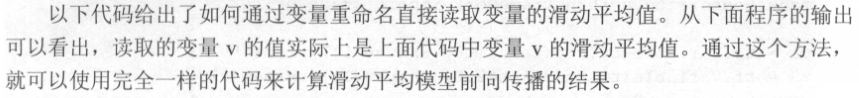

In [5]:
v = tf.Variable(0, dtype=tf.float32, name='v')
# 通过变量重命名将原来变量v的滑动平均值直接赋值给v

saver = tf.train.Saver({'v/ExponentialMovingAverage': v})

with tf.Session() as sess:
    saver.restore(sess, '/opt/jupyter_files/model-saves/maintain_averages_op/maintain_averages_op.ckpt')
    # 输出的值就是原来模型中变量v的滑动平均值
    print(sess.run(v))

INFO:tensorflow:Restoring parameters from /opt/jupyter_files/model-saves/maintain_averages_op/maintain_averages_op.ckpt
0.099999905


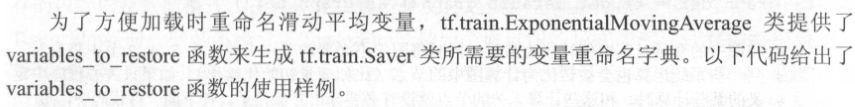

In [13]:
import tensorflow as tf

tf.reset_default_graph()

v = tf.Variable(0, dtype=tf.float32, name='v')
ema = tf.train.ExponentialMovingAverage(0.99)

# 通过使用variables_to_restore函数可以直接生成上面代码中提供的字典
print(ema.variables_to_restore())

saver = tf.train.Saver(ema.variables_to_restore())

with tf.Session() as sess:
    saver.restore(sess, '/opt/jupyter_files/model-saves/maintain_averages_op/maintain_averages_op.ckpt')
    print(sess.run(v))

{'v/ExponentialMovingAverage': <tf.Variable 'v:0' shape=() dtype=float32_ref>}
INFO:tensorflow:Restoring parameters from /opt/jupyter_files/model-saves/maintain_averages_op/maintain_averages_op.ckpt
0.099999905


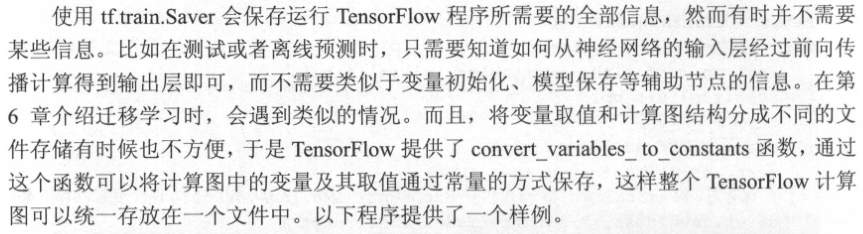

In [17]:
import tensorflow as tf
from tensorflow.python.framework import graph_util

v1 = tf.Variable(tf.constant(1.0, shape=[1]), name='v1')
v2 = tf.Variable(tf.constant(2.0, shape=[1]), name='v2')
result = v1 + v2

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    
    # 导出当前计算图的GraphDef部分，只需要这一部分就可以完成从输入层到输出层的计算过程
    graph_def = tf.get_default_graph().as_graph_def()
    
    # 将图中的变量及其取值转化为常量，同时将图中不必要的节点去掉
    # 下面代码中，最后一个参数['add']给出了需要保存的节点名称，add节点即两个变量相加操作
    # 注意这里给出的是计算节点的名称，所有没有后面的:0
    output_graph_def = graph_util.convert_variables_to_constants(sess,
                                                               graph_def,
                                                               ['add'])
    # 将导出的模型存入文件
    with tf.gfile.GFile('/opt/jupyter_files/model-saves/sub_save/model.pb', 'wb') as f:
        f.write(output_graph_def.SerializeToString())

INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.


In [18]:
import tensorflow as tf
from tensorflow.python.platform import gfile

with tf.Session() as sess:
    model_filename = '/opt/jupyter_files/model-saves/sub_save/model.pb'
    # 读取保存的模型文件，并将文件解析成对应的GraphDef Protocol Buffer
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        
    # 将graph_def中保存的图加载到当前的图中
    # 在保存的时候给出的是计算节点的名称，所以为'add'
    # 在加载的时候给出的是张量的名称，所以是add:0
    result = tf.import_graph_def(graph_def, return_elements=['add:0'])
    print(sess.run(result))

[array([3.], dtype=float32)]


# 持久化数据格式
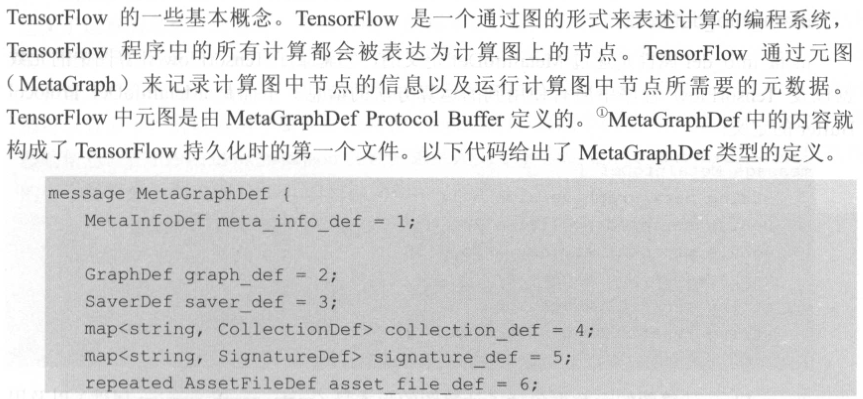

In [21]:
import tensorflow as tf

tf.reset_default_graph()

# 定义变量相加的计算
v1 = tf.Variable(tf.constant(1.0, shape=[1]), name='v1')
v2 = tf.Variable(tf.constant(2.0, shape=[1]), name='v2')
result = v1 + v2

saver = tf.train.Saver()
# 通过export_meta_graph函数导出Tensorflow计算图的元图，并保存为json格式
saver.export_meta_graph('/opt/jupyter_files/model-saves/v1_and_v2/v1_and_v2.ckpt.meta.json',
                       as_text=True)

meta_info_def {
  stripped_op_list {
    op {
      name: "Add"
      input_arg {
        name: "x"
        type_attr: "T"
      }
      input_arg {
        name: "y"
        type_attr: "T"
      }
      output_arg {
        name: "z"
        type_attr: "T"
      }
      attr {
        name: "T"
        type: "type"
        allowed_values {
          list {
            type: DT_HALF
            type: DT_BFLOAT16
            type: DT_FLOAT
            type: DT_DOUBLE
            type: DT_UINT8
            type: DT_INT8
            type: DT_INT16
            type: DT_INT32
            type: DT_INT64
            type: DT_COMPLEX64
            type: DT_COMPLEX128
            type: DT_STRING
          }
        }
      }
    }
    op {
      name: "Assign"
      input_arg {
        name: "ref"
        type_attr: "T"
        is_ref: true
      }
      input_arg {
        name: "value"
        type_attr: "T"
      }
      output_arg {
        name: "output_ref"
        type_attr: "T"
        

## meta_info_def属性
在.ckpt.meta.json文件中，其属性里只有stripped_op_list属性是不为空的。stripped_op_list属性记录了Tensorflow计算图上使用到的所有运算方法的信息。注意stripped_op_list属性保存的是Tensorflow运算方法的信息，如果某一个运算在Tensorflow计算图中出现了多次，那么在stripped_op_list也只会出现一次。stripped_op_list属性的类型是OpList，该类型是一个OpDef类型的列表
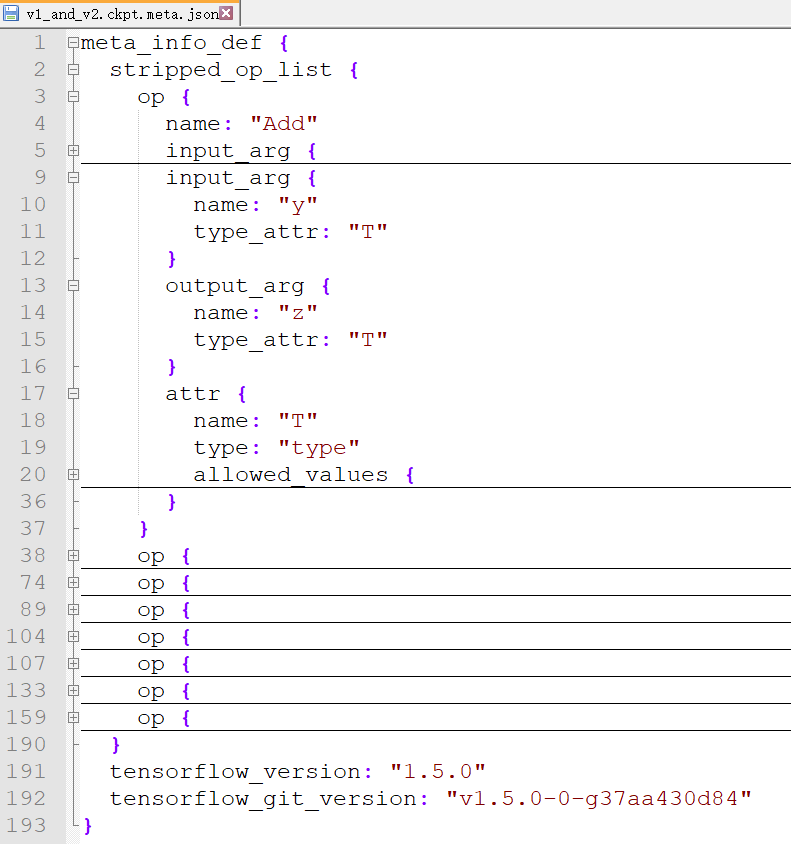

## graph_def属性
graph_def属性主要记录了Tensorflow计算图上的节点信息。每个节点对应了Tensorflow程序中的一个运算。因为是meta_info_def属性中已经包含了所有运算的具体信息，所以graph_def属性只关注运算的连接结构。
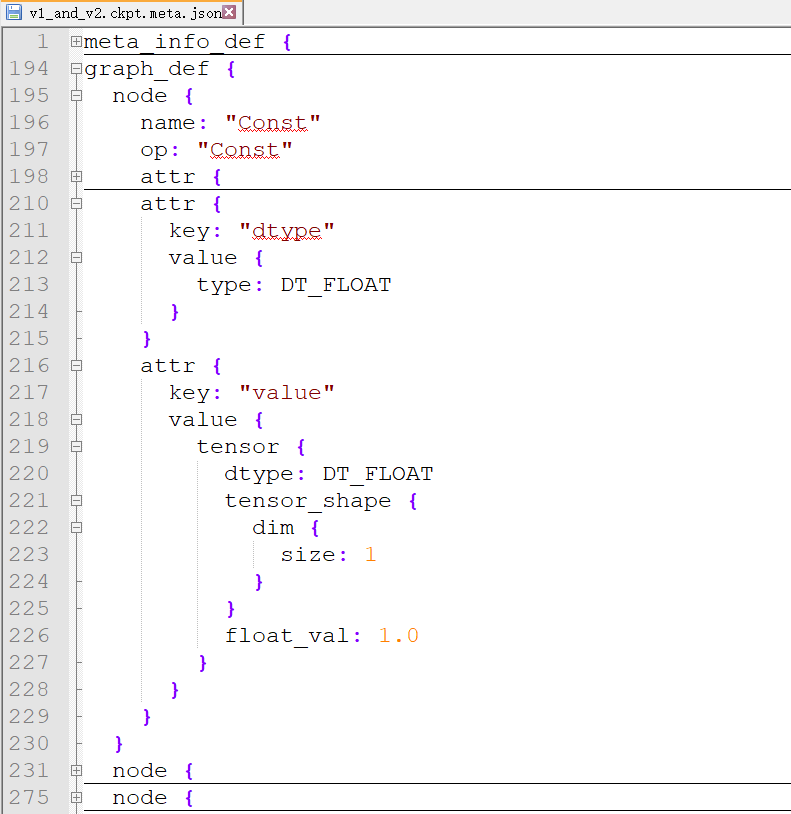

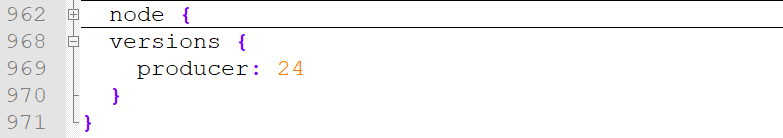

## saver_def属性
saver_def属性记录了持久化模型时需要用到的一些参数，比如保存到文件的文件名、保存操作和加载操作的名称以及保存频率、清理历史记录等。其中filename_tensor_name属性给出了保存文件名的张量名称，save_tensor_name属性给出了持久化模型的运算所对应的节点名称。restore_op_name表示加载运算名称。max_to_keep和keep_checkpoint_every_n_hours设定了tf.train.Saver类清理之前保存的模型的策略。比如当max_to_keep为5的时候，第六次调用saver.save时，第一次保存的模型就会被自动删除，通过设置keep_checkpoint_every_n_hours，每n小时可以在max_to_keep的基础上多保存一个模型
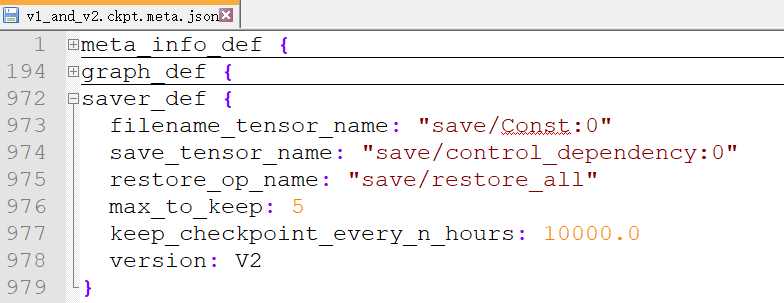

## collection_def属性
维护不同集合的底层实现。该属性是一个从集合名称到集合内容的映射，其中集合名称为字符串，而集合内容为CollectionDef Protocol Buffer。如下维护了两个集合，一个是所有变量的集合variables，一个是可训练变量的集合trainable_variables，这两个集合中的元素是一样的，都是变量v1和v2，它们都是系统自动维护的
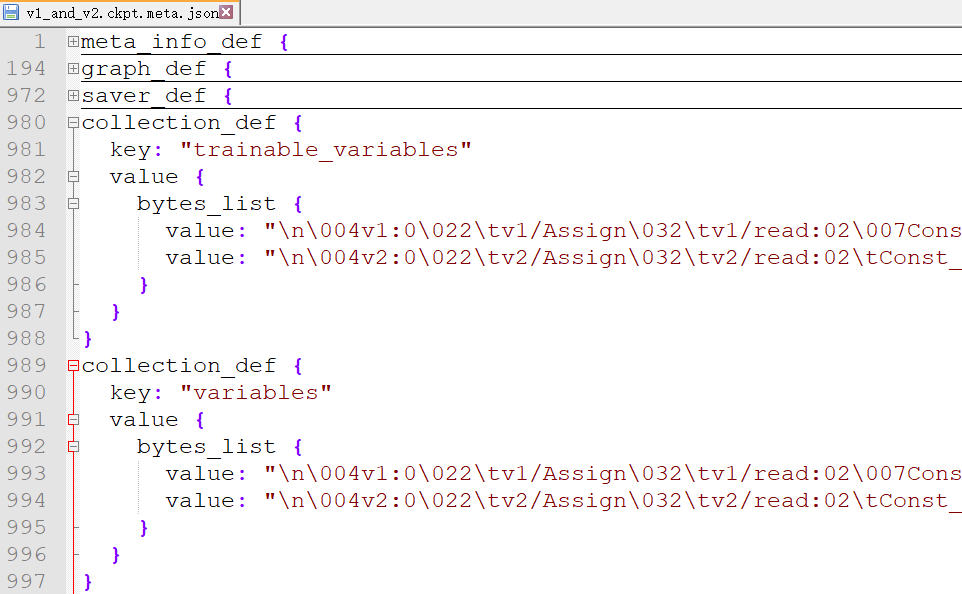

In [22]:
# 查看保存的变量信息
import tensorflow as tf

tf.reset_default_graph()

#下述函数可以读取checkpoint文件中保存的所有变量
# 注意后面的.data和.index可以省去
reader = tf.train.NewCheckpointReader('/opt/jupyter_files/model-saves/v1_and_v2/v1_and_v2.ckpt')

# 获取所有变量列表。这个是一个从变量名到变量维度的字典
global_variables = reader.get_variable_to_shape_map()
for variable_name in global_variables:
    # 分别输出变量名称和变量维度
    print(variable_name, global_variables[variable_name])
    
# 获取名称为v1的变量的取值
print('Value for variable v1 is ', reader.get_tensor('v1'))

v1 [1]
v2 [1]
Value for variable v1 is  [1.]


# MNIST数字识别最佳实践

In [2]:
# 定义了前向传播的过程以及神经网络的参数。实际可单独放入一个文件，如mnist_inference.py
# -*- coding: utf-8 -*-
import tensorflow as tf

# 定义神经网络结构相关的参数
INPUT_NODE = 784
OUTPUT_NODE = 10
LAYER1_NODE = 500

# 通过tf.get_variable函数来获取变量，在训练神经网络时会创建这些变量
# 在测试时会通过保存的模型加载这些变量的取值
# 因为可以在变量加载时将滑动平均变量重命名
# 所以可以直接通过相同的名字在训练时使用变量自身，而在测试时使用变量的滑动平均值
# 在这个函数中也会将变量的正则化损失加入损失集合
def get_weight_variable(shape, regularizer):
    weights = tf.get_variable('weights',
                              shape,
                             initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    # 当给出了正则化生成函数时，将当前变量的正则化损失加入名字为losses的集合
    # 在这里使用了add_to_collection函数将一个张量加入一个集合
    # 而这个集合的名称为losses，这是自定义集合，不在Tensorflow自动管理的集合列表中
    if regularizer != None:
        tf.add_to_collection('losses', regularizer(weights))
        
    return weights

# 定义神经网络的前向传播过程
def inference(input_tensor, regularizer):
    # 声明第一层神经网络的变量并完成前向传播过程
    with tf.variable_scope('layer1'):
        # 这里通过tf.get_variable或tf.Variable没有本质区别
        # 因为在训练或是测试中没有在同一个程序中多次调用这个函数
        # 如果在同一个程序中多次调用，在第一次调用之后需要将reuse参数设置为True
        weights = get_weight_variable([INPUT_NODE, LAYER1_NODE], regularizer)
        biases = tf.get_variable('biases',
                                 [LAYER1_NODE],
                                initializer=tf.constant_initializer(0.0))
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights) + biases)
    
    # 类似的声明第二层神经网络的变量并完成前向传播过程
    with tf.variable_scope('layer2'):
        weights = get_weight_variable([LAYER1_NODE, OUTPUT_NODE], regularizer)
        biases = tf.get_variable('biases',
                                 [OUTPUT_NODE],
                                initializer=tf.constant_initializer(0.0))
        layer2 = tf.matmul(layer1, weights) + biases
    
    # 返回最后前向传播的结果
    return layer2

In [3]:
# 定义了神经网络的训练程序。实际可单独放入一个文件，如mnist_train.py
# -*- coding: utf-8 -*-
import tensorflow as tf
import os
from tensorflow.examples.tutorials.mnist import input_data

# 加载mnist_inference.py中定义的常量和前向传播的函数（本例是上述程序）
# import mnist_inference

tf.reset_default_graph()

# 配置神经网络的参数
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARAZTION_RATE = 0.0001
TRAINING_STEPS = 30000
MOVING_AVERAGE_DECAY = 0.99

# 模型保存的路径和文件名
MODEL_SAVE_PATH = '/opt/jupyter_files/model-saves/mnist_model/'
MODEL_NAME = 'mnist.ckpt'

def train(mnist):
    # 定义输入输出placeholder（用到了上述程序的变量）
    x = tf.placeholder(tf.float32,
                      [None, INPUT_NODE],
                      name='x-input')
    y_ = tf.placeholder(tf.float32,
                       [None, OUTPUT_NODE],
                       name='y-input')
    
    regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
    # 直接使用mnist_inference.py中定义的前向传播过程
    y = inference(x, regularizer)
    global_step = tf.Variable(0, trainable=False)
    
    # 定义滑动平均操作、损失函数、学习率以及训练过程
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY,
                                                         global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y,
                                                                  labels=tf.argmax(y_, 1))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    # staircase=True 表示每隔 mnist.train.num_examples / BATCH_SIZE 步对学习率进行一次更新，否则每步更新
    learning_rate = tf.train.exponential_decay(LEARNING_RATE_BASE,
                                              global_step,
                                              mnist.train.num_examples / BATCH_SIZE,
                                              LEARNING_RATE_DECAY,
                                              staircase=True)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,
                                                                         global_step)
    with tf.control_dependencies([train_step, variables_averages_op]):
        train_op = tf.no_op(name='train')
        
    # 初始化Tensorflow持久化类，max_to_keep参数指定保留多少最新模型信息
    saver = tf.train.Saver(max_to_keep=10)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        # 在训练过程中不再测试模型在验证数据上的表现
        # 验证和测试的过程将会有一个独立的程序来完成
        for i in range(TRAINING_STEPS):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            _, loss_value, step = sess.run([train_op, loss, global_step],
                                          feed_dict={x: xs, y_: ys})
            
            # 每1000轮保存一次模型
            if i % 1000 == 0:
                # 输出当前的训练情况，这里只输出了模型在当前训练batch上的损失函数大小
                # 通过损失函数的大小可以大概了解训练的情况
                # 在验证数据集上的正确率信息会有一个单独的程序来生成
                print('After %d training step(s), loss on training batch is %g.'
                      % (step, loss_value))
                #  保存当前模型。注意这里给出了global_step参数
                # 可以让每个被保存模型的文件名末尾加上训练的轮数
                saver.save(sess,
                          os.path.join(MODEL_SAVE_PATH, MODEL_NAME),
                          global_step=global_step)
                
def main(argv=None):
    mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST', False, one_hot=True)
    train(mnist)
    
if __name__ == '__main__':
    tf.app.run()

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz
After 1 training step(s), loss on training batch is 3.30479.
After 1001 training step(s), loss on training batch is 0.356753.
After 2001 training step(s), loss on training batch is 0.154501.
After 3001 training step(s), loss on training batch is 0.159669.
After 4001 training step(s), loss on training batch is 0.139572.
After 5001 training step(s), loss on training batch is 0.112665.
After 6001 training step(s), loss on training batch is 0.100176.
After 7001 training step(s), loss on training batch is 0.0999449.
After 8001 training step(s), loss on training batch is 0.0795425.
After 9001 training step(s), loss on training batch is 0.0709949.
After 10001 training step(s), loss on training batch is 0.0718349.
After 11001 training step(s), loss

SystemExit: 

/opt/Anaconda/envs/tensorflow1.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# 定义了神经网络的测试程序。实际可单独放入一个文件，如mnist_eval.py
# -*- coding: utf-8 -*-
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 加载上述两个程序
# import mnist_inference
# import mnist_train

tf.reset_default_graph()

# 每10秒加载一次最新的模型，并在测试数据上测试最新模型的正确率
EVAL_INTERVAL_SECS = 10

def evaluate(mnist):
    with tf.Graph().as_default() as g:
        # 定义输入输出的格式
        x = tf.placeholder(tf.float32,
                          [None, INPUT_NODE],
                          name='x-input')
        y_ = tf.placeholder(tf.float32,
                           [None, OUTPUT_NODE],
                           name='y-input')
        validate_feed = {x: mnist.validation.images,
                        y_: mnist.validation.labels}
        
        # 直接通过调用封装好的函数来计算前向传播的结果
        # 因为测试时不关注正则化损失的值，所以这里用于计算正则化损失的函数被设置为None
        y = inference(x, None)
        
        # 使用前向传播的结果计算正确率
        # 如需对未知的样例进行分类，那么使用tf.argmax(y, 1)即可得到输入样例的预测类别了
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # 通过变量重命名的方式来加载模型
        # 这样在前向传播的过程中就不需要调用求滑动平均的函数来获取平均值了
        # 这样就可以完全共用mnist_inference.py中定义的前向传播过程
        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        
        # 每隔EVAL_INTERVAL_SECS秒调用一次计算正确率的过程以检测训练过程中正确率的变化
        while True:
            with tf.Session() as sess:
                # 下述函数会通过checkpoint文件自动找到目录中最新模型的文件名
                ckpt = tf.train.get_checkpoint_state(MODEL_SAVE_PATH)
                if ckpt and ckpt.model_checkpoint_path:
                    # 加载模型
                    saver.restore(sess, ckpt.model_checkpoint_path)
                    # 通过文件名得到模型保存时迭代的轮数
                    global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                    accuracy_score = sess.run(accuracy, feed_dict=validate_feed)
                    print('After %s training step(s), validation accuracy = %g' 
                         % (global_step, accuracy_score))
                else:
                    print('No checkpoint file found')
                    return
            time.sleep(EVAL_INTERVAL_SECS)
            
def main(argv=None):
    mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST', False, one_hot=True)
    evaluate(mnist)
    
if __name__ == '__main__':
    tf.app.run()

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from /opt/jupyter_files/model-saves/mnist_model/mnist.ckpt-29001
After 29001 training step(s), validation accuracy = 0.986
INFO:tensorflow:Restoring parameters from /opt/jupyter_files/model-saves/mnist_model/mnist.ckpt-29001
After 29001 training step(s), validation accuracy = 0.986
INFO:tensorflow:Restoring parameters from /opt/jupyter_files/model-saves/mnist_model/mnist.ckpt-29001
After 29001 training step(s), validation accuracy = 0.986
INFO:tensorflow:Restoring parameters from /opt/jupyter_files/model-saves/mnist_model/mnist.ckpt-29001
After 29001 training step(s), validation accuracy = 0.986
INFO:tensorflow:Restoring parameters from /opt/jupyter_files/model-saves/mnist_model/mnist.ckpt-29001
After 29

KeyboardInterrupt: 

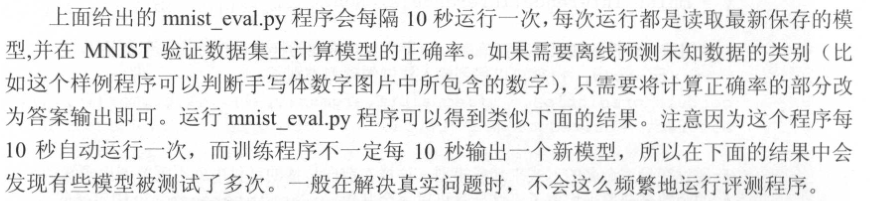